In [1]:
from pprint import pprint 
from pathlib import Path
import dataclasses
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import altair as alt
import umap.umap_ as umap
import numpy as np
import matplotlib.pyplot as plt
import requests
import time
import safetensors
import sklearn

import IPython.display as ipy_display
sns.set_style('darkgrid')

from safetensors.torch import safe_open
from sklearn.preprocessing import StandardScaler

# Utility Functions

In [4]:
from __future__ import annotations

from typing import Sequence
from torch import Tensor
from jaxtyping import Float, Integer
from enum import StrEnum, auto

StringArray = Sequence[str]
Array = Tensor | np.ndarray
ArrayInt = Integer[Array, 'n']
DiscreteArray = ArrayInt | StringArray

@dataclasses.dataclass
class SplitTuple:
    train : Sequence[int]
    val: Sequence[int]
    test: Sequence[int]
    
    def __post_init__(self):
        """Raises error if split parts overlap."""
        for a, b in [('train', 'val'), ('val', 'test'), ('test', 'train')]:
            overlap = np.intersect1d(getattr(self, a), getattr(self, b))
            if overlap.shape[0]:
                raise ValueError(
                    f'Found {len(overlap)} overlapping items between {a} and {b}.'
                )
    
    def __len__(self) -> int:
        return len(self.train) + len(self.val) + len(self.test)

    def trainval(self) -> DiscreteArray:
        return np.concatenate([self.train, self.val], axis=0)

    def indices(self) -> DiscreteArray:
        return np.concatenate([self.train, self.val, self.test], axis=0)

    def as_dict(self) -> dict[str, DiscreteArray]:
        return dataclasses.asdict(self)
    
    @classmethod
    def from_lists(
        cls,
        train: DiscreteArray,
        val: DiscreteArray,
        test: DiscreteArray
    ) -> 'SplitTuple':
        return cls(
            train=np.asarray(train),
            val=np.asarray(val),
            test=np.asarray(test)
        )
        
def load_embeddings(file):
    tensors = {}
    with safetensors.safe_open(str(file), framework='pt') as f:
        for k in f.keys():
            tensors[k] = f.get_tensor(k).numpy()
    return tensors
    
class ArrayMap:
    """Map discrete values (sequences, int, smiles) to arrays."""

    def __init__(self, keys, values):

        self.mapper = pd.Series(data=np.arange(len(keys)), index=keys)
        self.values = values
        # Check for duplicates.
        dups = self.mapper.index[self.mapper.index.duplicated()].tolist()
        if dups:
            raise ValueError(f'Found {len(dups)} duplicated isosmiles={dups}')
    
    @classmethod
    def from_dict(cls, adict) -> ArrayMap:
        return ArrayMap(np.array(list(adict.keys())), np.stack(list(adict.values())))

    @classmethod
    def load(cls, fname: str) -> ArrayMap:
        data = load_embeddings(fname)
        return cls.from_dict(data)

    @property
    def keys(self):
        return list(self.mapper.index)
        

    def __call__(self, key_array: types.DiscreteArray):
        assert isinstance(key_array, np.ndarray), 'expected np.ndarray as input!'
        return self.values[self.mapper[key_array].values]
        
def html_header(text:str, n:int = 2)-> None:
    ipy_display.display(ipy_display.HTML(f'<h{n}>{text}</h{n}>'))

    
def peek_df(df:pd.DataFrame, title:str=None, n=5)-> None:
    if title:
        if is_notebook():
            html_header(f'{title:-^30}')
        else:
            print(f'{title:-^30}')
        
    print(f'Columns: {df.columns}')
    print(f'Shape: {df.shape}')
    if n > 0 and is_notebook():
        ipy_display.display(df.head(n=n))

def estimate_clusters_silhouette(embeddings, max_k=10):
    embeddings_norm = sklearn.preprocessing.normalize(embeddings, norm='l2', axis=1)
    silhouette_scores = []
    k_range = range(2, max_k + 1)
    for k in k_range:
        kmeans = sklearn.cluster.KMeans(n_clusters=k, random_state=42, n_init=10)
        cluster_labels = kmeans.fit_predict(embeddings_norm)
        score = sklearn.metrics.silhouette_score(embeddings, cluster_labels, metric='cosine')
        silhouette_scores.append(score)

    best_k = k_range[np.argmax(silhouette_scores)]
    return best_k
    
def plot_pairwise_distances(embeddings, labels, cmap, name):
    dist_matrix = sklearn.metrics.pairwise_distances(embeddings, metric='cosine')
    n_clusters = estimate_clusters_silhouette(embeddings)
    sc = sklearn.cluster.SpectralClustering(n_clusters=n_clusters, assign_labels='kmeans', random_state=42)
    cluster_labels = sc.fit_predict(embeddings)
    sorted_indices = np.argsort(cluster_labels)
    plot_matrix = dist_matrix[sorted_indices, :][:, sorted_indices]
    labels = np.array(labels)[sorted_indices]

    
    fig = plt.figure(figsize=(12, 14)) # Adjusted figsize for hist+heatmap
    gs = gridspec.GridSpec(2, 1, height_ratios=[1, 5], hspace=0.05)
    ax_hist = fig.add_subplot(gs[0, 0])
    ax_heatmap = fig.add_subplot(gs[1, 0])

    upper_triangle_indices = np.triu_indices_from(dist_matrix, k=1)
    distances = dist_matrix[upper_triangle_indices]

    ax_hist.hist(distances, bins=50, color='grey', alpha=0.7, density=True)
    sns.kdeplot(distances, color='black', ax=ax_hist, warn_singular=False)
    ax_hist.set_title(f'Pairwise Cosine Distances {name}')
    ax_hist.set_xlim(0.0, max(1.0, np.max(distances) * 1.05) if distances.size > 0 else 1.0)
    ax_hist.set_ylabel('Density')
    ax_hist.xaxis.tick_top()
    ax_hist.xaxis.set_label_position('top')

    heatmap_plot = sns.heatmap(
        plot_matrix,
        cmap=cmap,
        square=True,
        cbar_kws={'label': 'Cosine Distance', 'shrink': 0.8},
        cbar_ax=fig.add_axes([0.92, 0.15, 0.02, 0.6]),
        vmin=0.0,
        vmax=max(1.0, np.max(plot_matrix) if plot_matrix.size > 0 else 1.0),
        xticklabels=labels,
        yticklabels=labels,
        ax=ax_heatmap
    )
    ax_heatmap.tick_params(axis='x', rotation=90)
    ax_heatmap.tick_params(axis='y', rotation=0)
    if len(labels) > 50:
         heatmap_plot.set_xticklabels(heatmap_plot.get_xticklabels(), size=6)
         heatmap_plot.set_yticklabels(heatmap_plot.get_yticklabels(), size=6)

    gs.tight_layout(fig, rect=[0, 0, 0.9, 1])

def fetch_uniprot_fasta(
    functions,
    kingdoms=None,
    batch_size=500,
    offset=0,
    length_range=None,
    reviewed=False,
    output_file=None,
    output_dir=None
):
    """
    Fetches protein sequences from UniProt in FASTA format, filtering by functional keywords
    and taxonomic kingdoms (Bacteria, Fungi, Metazoa, Viridiplantae, Protista).
    
    Parameters:
    - functions: list of functional keywords, e.g., ["oxidase", "reductase"]
    - kingdoms: list of kingdoms to include, e.g. ["Bacteria", "Fungi", "Metazoa", "Viridiplantae", "Protista"]
    - batch_size: number of entries per request (max 500)
    - offset: start index for fetching
    - length_range: tuple (min_length, max_length) for sequence length
    - reviewed: True for Swiss-Prot only, False for TrEMBL only
    - output_file: path to save the FASTA results
    """
    base_url = "https://rest.uniprot.org/uniprotkb/search"
    
    kingdom_map = {
        "Bacteria":            "taxonomy_id:2",
        "Fungi":               "taxonomy_id:4751",
        "Metazoa":             "taxonomy_id:33208",
        "Viridiplantae":       "taxonomy_id:33090",
        "Protista":            "(taxonomy_id:2759 NOT taxonomy_id:33208 NOT taxonomy_id:33090 NOT taxonomy_id:4751)"
    }
    
    if output_file is None:
        func_str = "_".join(functions) if functions else "anyfunc"
        kingdoms_str = "_".join(kingdoms) if kingdoms else "anykingdom"
        length_str = f"_{length_range[0]}-{length_range[1]}" if length_range else ""
        reviewed_str = "_reviewed" if reviewed else "_unreviewed"
        output_file = f"{func_str}_{kingdoms_str}{length_str}{reviewed_str}.fasta"

    if output_dir is None:
        output_dir = '.'
    output_path = Path(output_dir) / output_file

    parts = []
    if functions:
        parts.append("(" + " OR ".join(functions) + ")")
    if reviewed is not None:
        parts.append(f"reviewed:{str(reviewed).lower()}")
    if length_range:
        parts.append(f"length:[{length_range[0]} TO {length_range[1]}]")
    if kingdoms:
        k_filters = [kingdom_map[k] for k in kingdoms if k in kingdom_map]
        if k_filters:
            parts.append("(" + " OR ".join(k_filters) + ")")
    query = " AND ".join(parts)
    
    params = {"query": query, "format": "fasta", "size": 1}
    resp = requests.get(base_url, params=params)
    total = int(resp.headers.get("x-total-results", 0))
    print(f"Found {total} entries for query: {query}")
    
    with open(output_file, "w") as out_f:
        for start in range(offset, total, batch_size):
            print(f"Fetching entries {start + 1}-{min(start + batch_size, total)}...")
            params = {
                "query": query,
                "format": "fasta",
                "size": batch_size,
                "offset": start
            }
            while True:
                try:
                    r = requests.get(base_url, params=params)
                    r.raise_for_status()
                    out_f.write(r.text)
                    break
                except Exception as e:
                    print(f"Error: {e}. Retrying in 5s...")
                    time.sleep(5)
    print(f"Download complete: {output_path}")

def read_fasta(file_path):
    """
    Reads a FASTA file and returns a dictionary of sequences.
    
    Parameters:
        file_path (str): Path to the FASTA file.
    
    Returns:
        dict: {header: sequence_string}
    """
    sequences = {}
    with open(file_path, 'r') as fasta_file:
        header = None
        seq_chunks = []
        for line in fasta_file:
            line = line.strip()
            if not line:
                continue
            if line.startswith('>'):
                # Save previous sequence
                if header is not None:
                    sequences[header] = ''.join(seq_chunks)
                # Start new record
                header = line[1:].split()[0]
                seq_chunks = []
            else:
                seq_chunks.append(line)
        # Save last record
        if header is not None:
            sequences[header] = ''.join(seq_chunks)
    return sequences

# Paths and Constants

In [5]:
class PathsAndConstants:
    data_path = Path('../data/processed')
    raw_path = Path('../data/raw')
    results_path = Path('../results/EDA results')
    label_csv = data_path / 'protein_substrate.csv'
    protein = 'protein_name'
    protein_embs = {'ESM2_T6': data_path / 'protein_esm2t6.safetensors', 'ESM2_T33': data_path / 'protein_esm2t33.safetensors'}
    mol = 'substrate_name'
    mol_embs = {'RDKit2D': data_path / 'substrate_rdkit2d.safetensors'}
    raw_label = 'value'
    measurement = 'Specific Activity'
    label = f'log10({measurement})'
    unit='μmol.min⁻¹.mg⁻¹'

_C = PathsAndConstants()
_C

# Exploratory Data Analysis

## Load Data

In [6]:
df = pd.read_csv(_C.label_csv)
df[_C.label]= np.log10(df[_C.raw_label])
print(df.columns)
print(df.shape)
df.head()

Index(['protein_name', 'substrate_name', 'substrate notes', 'measurement',
       'units', 'value', 'variance', 'log10(Specific Activity)'],
      dtype='object')
(385, 8)


,protein_name,substrate_name,substrate notes,measurement,units,value,variance,log10(Specific Activity)
0,ExeGalOx,D-Galactose,300mM,Specific Activity,μmol.min⁻¹.mg⁻¹,20.70,0.42,1.315970
1,MreGalOx,D-Galactose,300mM,Specific Activity,μmol.min⁻¹.mg⁻¹,5.73,1.72,0.758155
2,PfeGalOx,D-Galactose,300mM,Specific Activity,μmol.min⁻¹.mg⁻¹,182.00,11.60,2.260071
3,FoxGalOxB,D-Galactose,300mM,Specific Activity,μmol.min⁻¹.mg⁻¹,60.70,5.77,1.783189
4,UmaRafOx,D-Galactose,300mM,Specific Activity,μmol.min⁻¹.mg⁻¹,0.17,0.01,-0.769551


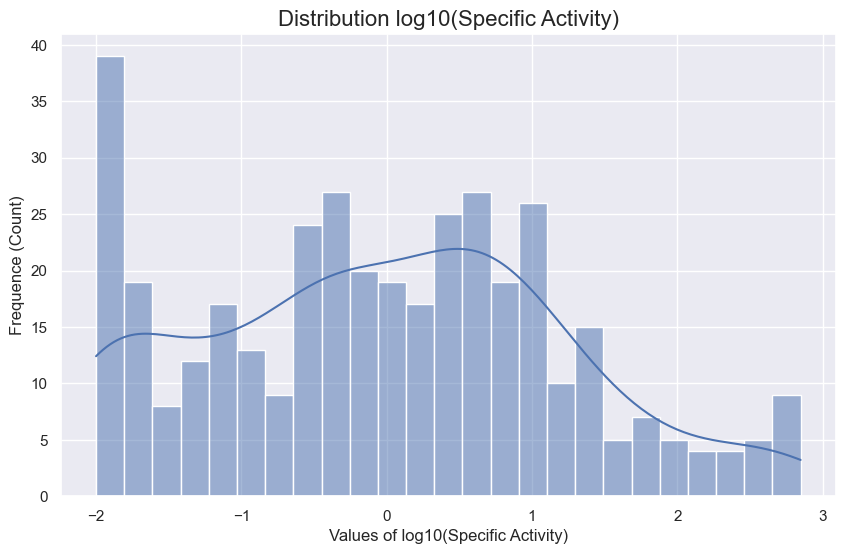

--- Statistics for'log10(Specific Activity)' ---
count    385.000000
mean      -0.028493
std        1.247428
min       -2.000000
25%       -1.000000
50%        0.012837
75%        0.800717
max        2.848189
Name: log10(Specific Activity), dtype: float64


In [10]:
sns.set_theme(style="darkgrid")
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x=_C.label, bins=25, kde=True)
plt.title(f'Distribution {_C.label}', fontsize=16)
plt.xlabel(f'Values of { _C.label }', fontsize=12)
plt.ylabel('Frequence (Count)', fontsize=12)
plt.show()

summary_stats = df[_C.label].describe()
print(f"--- Statistics for'{_C.label}' ---")
print(summary_stats)

In [6]:
protein_embs6 = {'ESM2_T6': ArrayMap.load(_C.protein_embs['ESM2_T6'])}
protein_embs33 = {'ESM2_T33': ArrayMap.load(_C.protein_embs['ESM2_T33'])}
mol_embs = {name: ArrayMap.load(file) for name, file in _C.mol_embs.items()}

In [7]:
print(mol_embs['RDKit2D'](np.array(['D-Galactose', 'D-Galactose'])).shape)
print(protein_embs6['ESM2_T6'](np.array(['FoxGalOxB', 'UmaRafOx'])).shape)
print(protein_embs33['ESM2_T33'](np.array(['FoxGalOxB', 'UmaRafOx'])).shape)

(2, 200)
(2, 320)
(2, 1280)


## Correlation

<Axes: xlabel='sequence', ylabel='Count'>

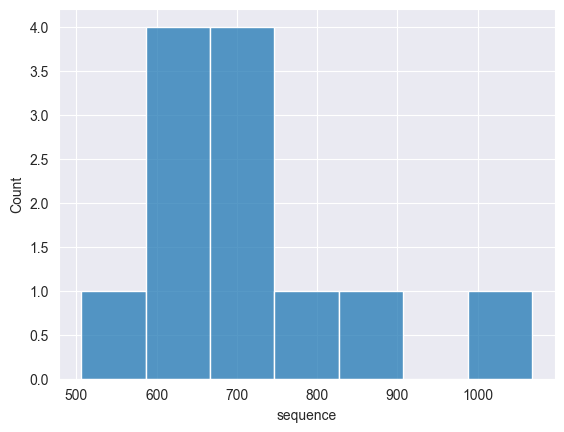

In [8]:
p_df = pd.read_csv(_C.data_path / 'proteins.csv')
seq_lens = p_df['sequence'].apply(len)
sns.histplot(seq_lens)

/tmp/ipykernel_14712/93996131.py:163: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  gs.tight_layout(fig, rect=[0, 0, 0.9, 1])


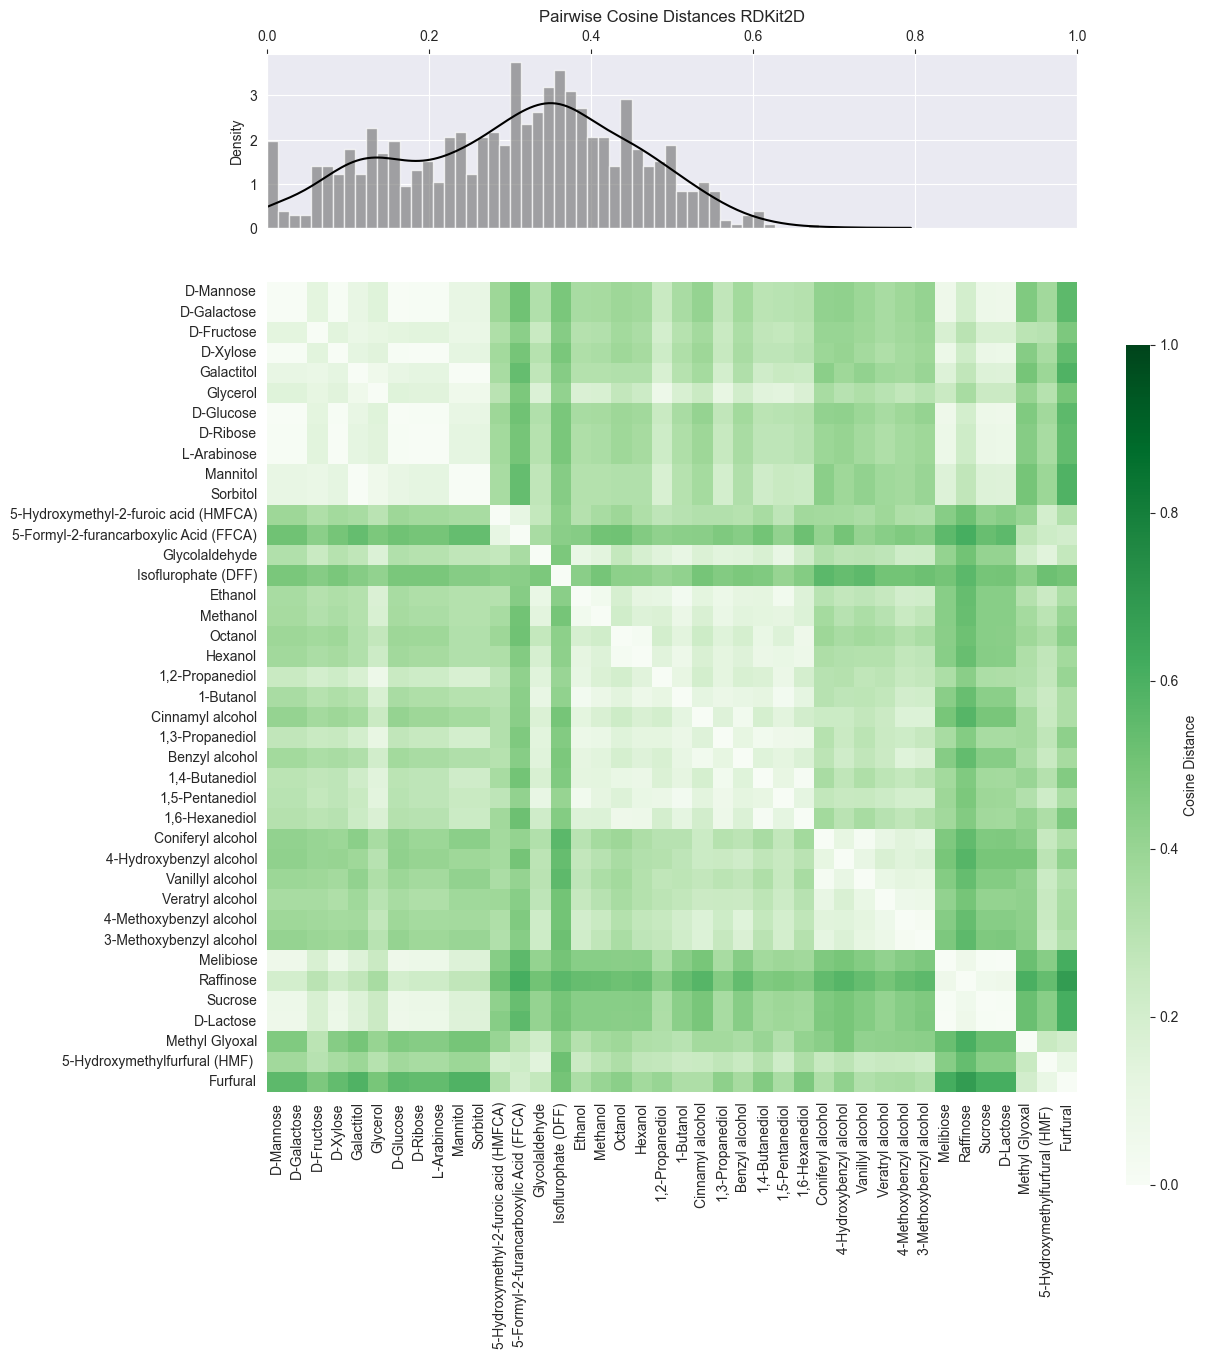

/tmp/ipykernel_14712/93996131.py:163: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  gs.tight_layout(fig, rect=[0, 0, 0.9, 1])


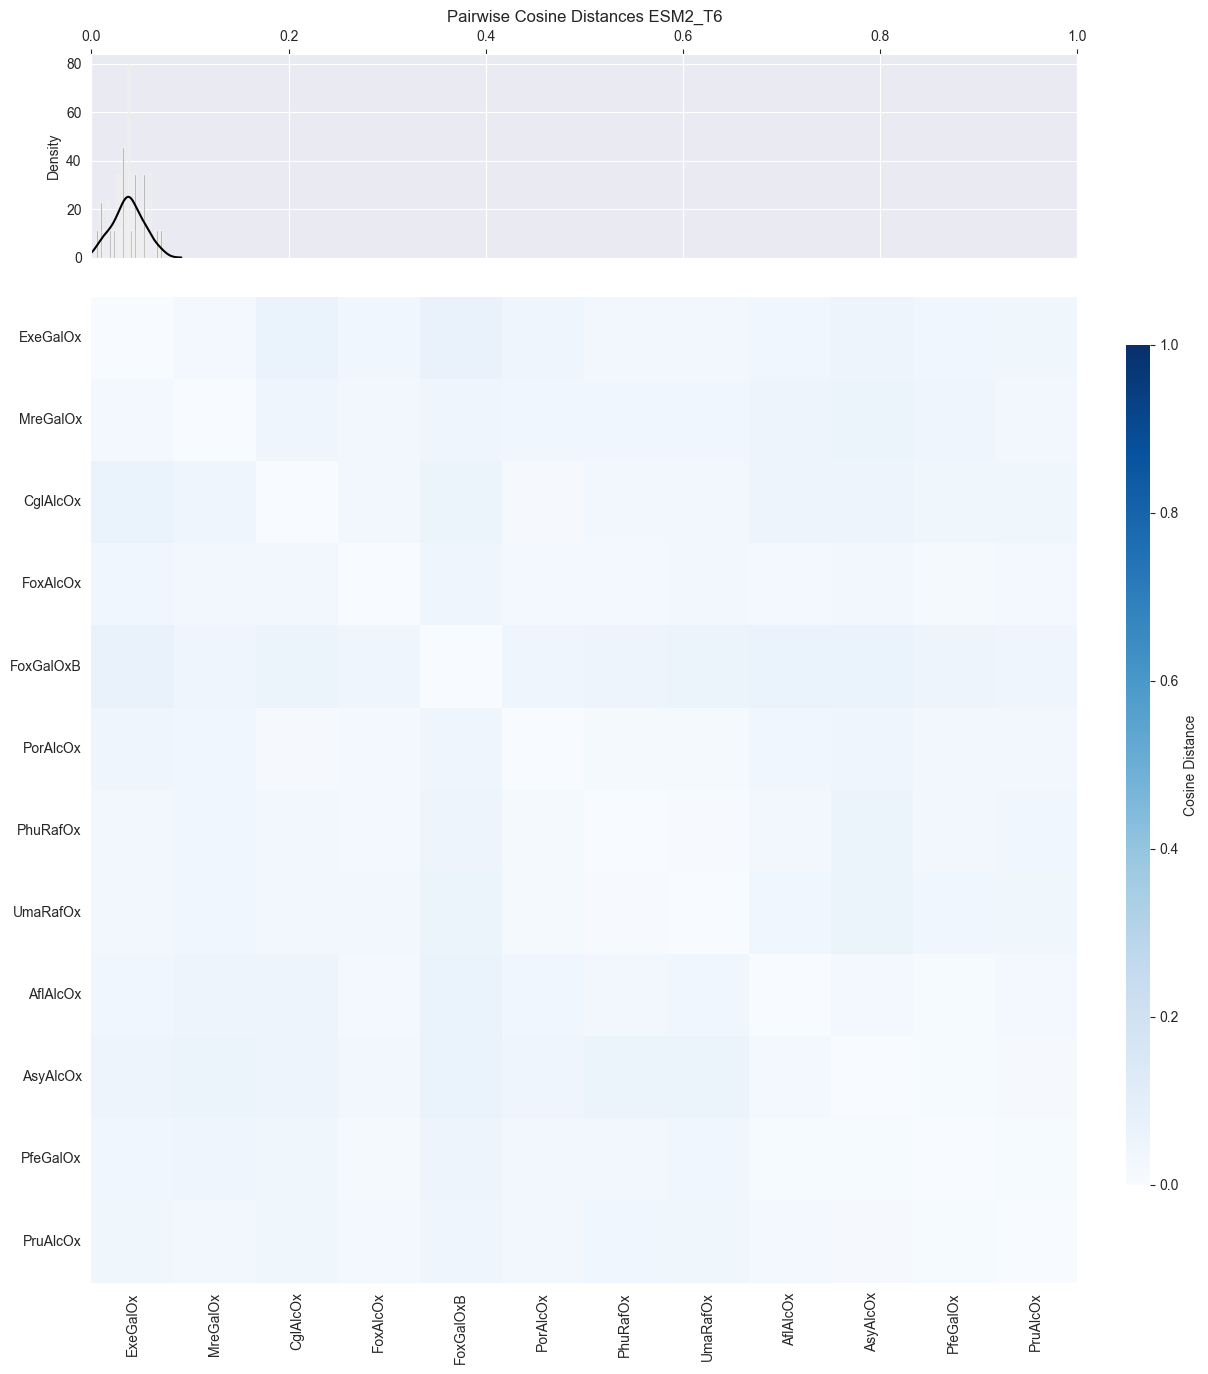

In [9]:
for name, emb_map in  mol_embs.items():
    plot_pairwise_distances(emb_map.values, emb_map.keys, 'Greens', name)
    plt.savefig(_C.results_path / 'substrate_correlation', dpi=300, bbox_inches='tight')
    plt.show()
for name, emb_map in  protein_embs6.items():
    plot_pairwise_distances(emb_map.values, emb_map.keys, 'Blues', name)
    plt.savefig(_C.results_path / 'enzyme_correlation', dpi=300, bbox_inches='tight')
    plt.show()

## Enzyme UMAP

In [9]:
embeddings6 = {}
embeddings33 = {}

with safe_open(_C.protein_embs['ESM2_T6'], framework="pt") as f:
    for key in f.keys():
        embeddings6[key] = f.get_tensor(key)
with safe_open(_C.protein_embs['ESM2_T33'], framework="pt") as f:
    for key in f.keys():
        embeddings33[key] = f.get_tensor(key)

protein_names = list(embeddings6.keys())
embedding_array6 = np.stack([embeddings6[name].numpy() for name in protein_names])
embedding_array33 = np.stack([embeddings33[name].numpy() for name in protein_names])

/home/josechemistry/miniforge3/envs/myenv/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/josechemistry/miniforge3/envs/myenv/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


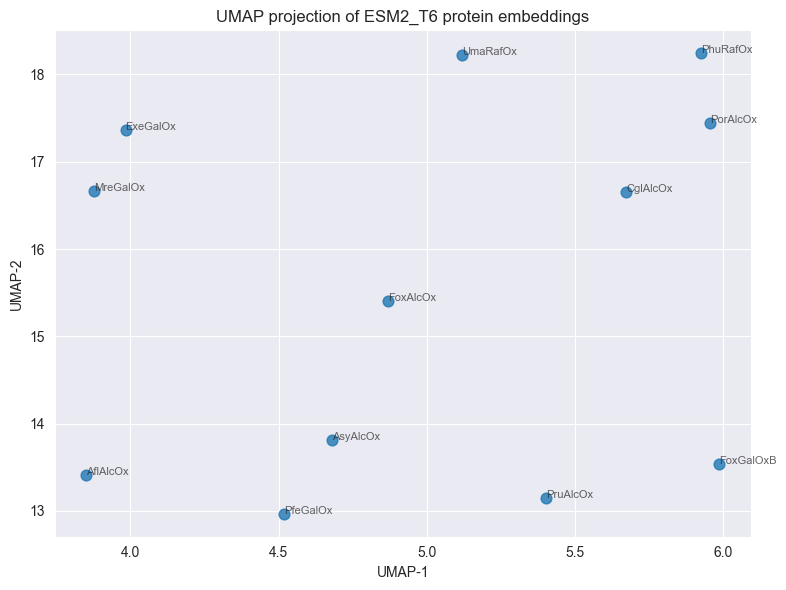

/home/josechemistry/miniforge3/envs/myenv/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


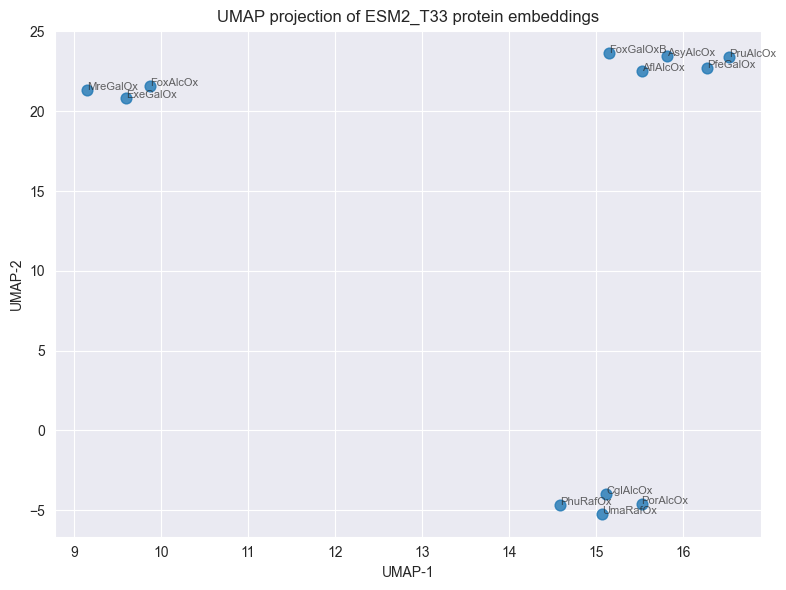

In [16]:
reducer = umap.UMAP(
    n_neighbors=3,
    min_dist=0.3,
    metric="cosine",
    random_state=42
)
embedding_umap = reducer.fit_transform(embedding_array6)
plt.figure(figsize=(8, 6))
plt.scatter(embedding_umap[:, 0], embedding_umap[:, 1], s=60, alpha=0.8)
for i, name in enumerate(protein_names):
    plt.text(embedding_umap[i, 0], embedding_umap[i, 1], name, fontsize=8, alpha=0.7)

plt.title("UMAP projection of ESM2_T6 protein embeddings")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.grid(True)
plt.tight_layout()
plt.savefig(_C.results_path / 'ESM2_T6_UMAP', dpi=300, bbox_inches='tight')
plt.show()

embedding_umap = reducer.fit_transform(embedding_array33)
plt.figure(figsize=(8, 6))
plt.scatter(embedding_umap[:, 0], embedding_umap[:, 1], s=60, alpha=0.8)
for i, name in enumerate(protein_names):
    plt.text(embedding_umap[i, 0], embedding_umap[i, 1], name, fontsize=8, alpha=0.7)

plt.title("UMAP projection of ESM2_T33 protein embeddings")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.grid(True)
plt.tight_layout()
plt.savefig(_C.results_path / 'ESM2_T33_UMAP', dpi=300, bbox_inches='tight')
plt.show()

## UMAP Substrates

In [23]:
embeddingsmol = {}

with safe_open(_C.mol_embs['RDKit2D'], framework="pt") as f:
    for key in f.keys():
        embeddingsmol[key] = f.get_tensor(key)

subs_names = list(embeddingsmol.keys())
mol_array = np.stack([embeddingsmol[name].numpy() for name in subs_names])

In [24]:
scaler = StandardScaler()
mol_scaled = scaler.fit_transform(mol_array)

reducer2 = umap.UMAP(
    n_neighbors=3,
    min_dist=0.2,
    metric="euclidean",
    random_state=42
)

mol_umap = reducer2.fit_transform(mol_array)
umap_df = pd.DataFrame({
    'UMAP-1': mol_umap[:, 0],
    'UMAP-2': mol_umap[:, 1],
    'Molecule': subs_names
})

chart = alt.Chart(umap_df).mark_circle(size=100, opacity=0.7).encode(
    x=alt.X('UMAP-1', scale=alt.Scale(zero=False)),
    y=alt.Y('UMAP-2', scale=alt.Scale(zero=False)),
    tooltip=['Molecule']
).properties(
    width=700,
    height=500,
    title="UMAP projection of Descriptastorus molecule embeddings (scaled)"
).interactive()

chart.save(_C.results_path / "substrates_umap.png") 
chart.display()

/home/josechemistry/miniforge3/envs/myenv/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/josechemistry/miniforge3/envs/myenv/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


alt.Chart(...)

# Data Search

In [13]:
fetch_uniprot_fasta(
     functions=["oxidoreductase"],
     kingdoms=["Bacteria"],
     length_range=(400, 1000),
     reviewed=False,
     output_dir=_C.raw_path
)

Found 4059783 entries for query: (oxidoreductase) AND reviewed:false AND length:[400 TO 1000] AND (taxonomy_id:2)
Fetching entries 1-500...
Fetching entries 501-1000...
Fetching entries 1001-1500...
Fetching entries 1501-2000...
Fetching entries 2001-2500...
Fetching entries 2501-3000...
Fetching entries 3001-3500...
Fetching entries 3501-4000...
Fetching entries 4001-4500...
Fetching entries 4501-5000...
Fetching entries 5001-5500...
Fetching entries 5501-6000...
Fetching entries 6001-6500...
Fetching entries 6501-7000...
Fetching entries 7001-7500...
Fetching entries 7501-8000...
Fetching entries 8001-8500...
Fetching entries 8501-9000...
Fetching entries 9001-9500...
Fetching entries 9501-10000...
Fetching entries 10001-10500...
Fetching entries 10501-11000...
Fetching entries 11001-11500...
Fetching entries 11501-12000...
Fetching entries 12001-12500...
Fetching entries 12501-13000...
Fetching entries 13001-13500...
Fetching entries 13501-14000...
Fetching entries 14001-14500...
Fe

In [ ]:
#Rework READ_FASTA function
seqs = read_fasta(_C.raw_path / 'oxidoreductase_Bacteria_400-1000_unreviewed.fasta')
print(len(seqs))
oxred_df = pd.DataFrame(list(seqs.items()), columns=['Accession', 'Sequence'])
print(oxred_df.head(5))
print(oxred_df.shape)
oxred_df.to_csv(_C.data_path / 'oxireductases.csv', index=False)

500
                Accession                                           Sequence
0  tr|M5DCM0|M5DCM0_9GAMM  MSDSIIKRLLRAIATVFSVSLLFVGNASADIPDELYEALGVDKYKA...
1  tr|Q9RAH7|Q9RAH7_NITS1  MRIGEWMRGLLLCAGLMMCGVVHADISTVPDETYDALKLDRGKATP...
2  tr|Q9RAH9|Q9RAH9_NITS1  MRIGEWMRGLLLCAGLMMCGVVHADISTVPDETYDALKLDRGKATP...
3  tr|Q9RAH8|Q9RAH8_NITS1  MRIGEWMRGLLLCAGLMMCGVVHADISTVPDETYDALKLDRGKATP...
4  tr|B3IXF6|B3IXF6_PSECI  MTTSSLLNGTRHTLHDHQQSHARVGTNEQARAIVHRTHGRVHGPVT...
(500, 2)
